In [57]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from showlib import * 

## CH3 強度轉換與空間濾波(Intensity Transformationa and Spatial Filtering)

空間域（spatial domain）轉換是相對於頻率域（frequency domain）進行的轉換。它直接作用於二維影像的像素。一般來說，此類運算更高效，所需資源也較少。

空間域轉換之目的很多，增強對比度(contrast enhancement)、濾除雜訊是其中之大課題。空間域轉換之手段可以透過強度轉換函數、空間濾波器等等。
常見之關鍵字:
強度轉換函數、空間濾波器、核、對比度擴展、直方圖等化

### CH3-1 基本強度轉換函數(Intensity Transformation Functions)
強度轉換函數之定義如下，其中$f(x,y)$為輸入之函數，$g(x,y)$為輸出函數，$T$則為連接兩者之轉移函數。此轉轉移函數用以實現圖片之強度之映射。此種方式用來實現影像處理之優點是簡單好用，但效果有限，畢竟是整體一起調整，對於圖片中相同像素強度但處於不同位置之像素處理方式會是相同的，無法起到影像分隔或是針對某特定範圍進行針對性處裡的效果。
$$g(x,y)=T[f(x,y)]$$

常見之轉換函數如下(橫軸為強度輸入準位，縱軸為強度輸出準位)

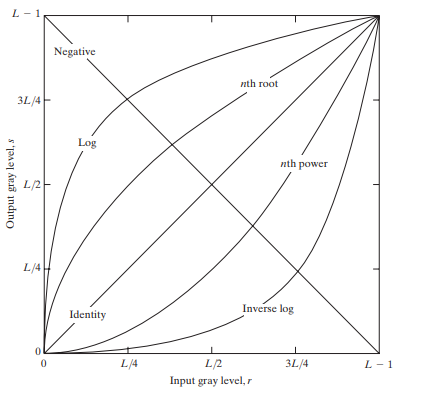



"恆等轉換(Identity Transformation)"，定義為$s = r$。<br />
"影像負片(Negative Transformation)"，定義為$s = L - 1 - r$。<br />
"Log 轉換(Log Transformation)"，定義為$s = c \log(1+r) $，c為常數，$r \ge 0$。(大量壓縮動態範圍，適合用在fft頻域圖大動態範圍之用)<br />
"乘冪率轉換(Gamma Transformation)"，定義為$s = c r^{\gamma} $，c，$\gamma$ 為正常數。$\gamma$各種值如下圖，$\gamma$與c為1時，為恆等轉換。<br />
"逐段線性轉換函數(PIECEWISE LINEAR TRANSFORMATION FUNCTIONS)"，使用分段函數進行定義。


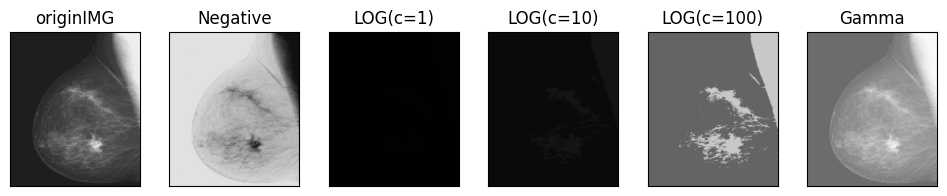

In [58]:
originIMG = cv2.imread('source_img/breast_digital_Xray.tif')
RGBIMG =  cv2.cvtColor(originIMG,cv2.COLOR_BGR2RGB)#cv2 read img in BGR, PLT shows in RGB
####->openCV 讀進來是uint ---> 沒有負，Negative Transformation其實可以直接 -RGBIMG 得到，但在這裡，先換成int更general。
RGBIMG=RGBIMG.astype('int')


Negative=255-RGBIMG#Negative Transformation
LogC1=1*np.log10(1+RGBIMG).astype('int')
LogC10=10*np.log10(1+RGBIMG).astype('int')
LogC100=100*np.log10(1+RGBIMG).astype('int')
Gamma=((((RGBIMG/255).astype('float'))**0.4)*255).astype('int');#輸入0~1
print()
show6plt(RGBIMG,Negative,LogC1,LogC10,LogC100,Gamma,n1="originIMG",n2="Negative",n3="LOG(c=1)",n4="LOG(c=10)",n5="LOG(c=100)",n6="Gamma")


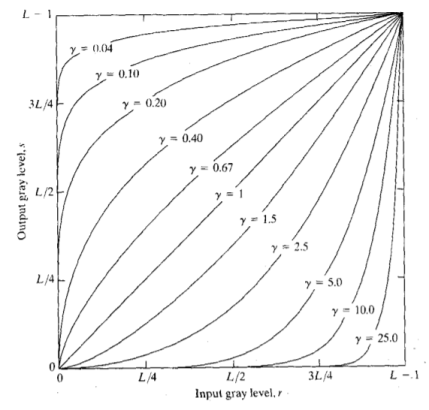

配合不同的gamma值可以達到不同的效果，一般來說gamma越小越有漂白的效果，小範圍的暗色部分被映射到較大的區域，而大部分中色調與亮部都被往亮部推，理論上暗部的解析準位對比變高。
越大會有增色變暗的效果，同樣的因為中色調被往暗處推，亮色調被映射到原本亮色與中色調的位置，範圍變大，理論上原本屬於亮部部分之對比度會提升。

gamma校正也被應用在色彩校正上，也就是拉曲線。

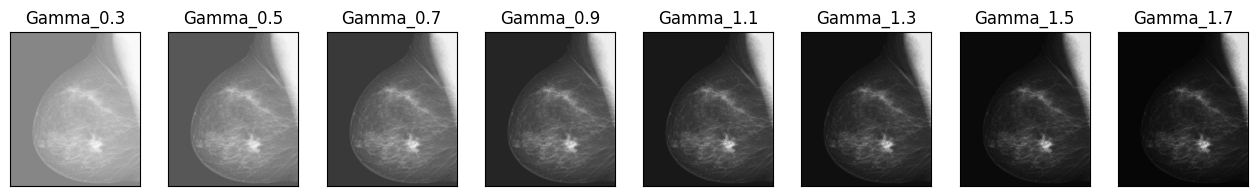

In [59]:
Gamma_03=((((RGBIMG/255).astype('float'))**0.3)*255).astype('int');
Gamma_05=((((RGBIMG/255).astype('float'))**0.5)*255).astype('int');
Gamma_07=((((RGBIMG/255).astype('float'))**0.7)*255).astype('int');
Gamma_09=((((RGBIMG/255).astype('float'))**0.9)*255).astype('int');
Gamma_11=((((RGBIMG/255).astype('float'))**1.1)*255).astype('int');
Gamma_13=((((RGBIMG/255).astype('float'))**1.3)*255).astype('int');
Gamma_15=((((RGBIMG/255).astype('float'))**1.5)*255).astype('int');
Gamma_17=((((RGBIMG/255).astype('float'))**1.7)*255).astype('int');

show8plt(Gamma_03,Gamma_05,Gamma_07,Gamma_09,Gamma_11,Gamma_13,Gamma_15,Gamma_17,
         n1="Gamma_0.3",n2="Gamma_0.5",n3="Gamma_0.7",n4="Gamma_0.9",n5="Gamma_1.1",n6="Gamma_1.3",n7="Gamma_1.5",n8="Gamma_1.7")

"對比度擴展(contract stretching)" 將輸入準位的某段小範圍映射到輸出準位的較大範圍，如下PL4。<br/>
"強度準位切片(Intensity-Level Slicing)" 如果對某一輸入準位有興趣，可以將他映射到輸出準位到一高對比位置，類似highlight作用。兩種常見方法是將感興趣的部分升至最高，其他則保持不變如下PL2。另一種則時將其他變成0，輸出為二值化影像，如下PL1。<br/>
位元平面切片(Bit-Plane Slicing) 是將圖片中某位元準位進行的切面，是強度準位切面的特例。可以用來看某一位元對整體圖片之貢獻分布。


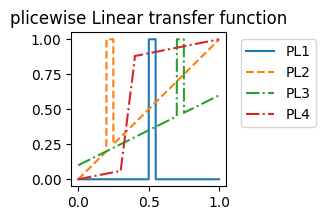

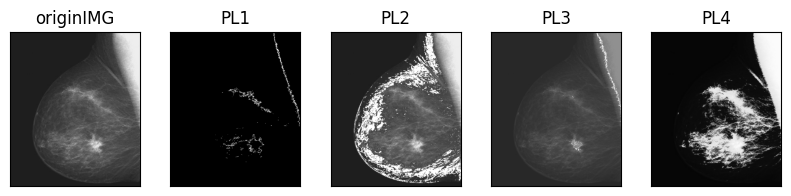

In [60]:
def Piecewise_linear1(input):
    return np.where((input > 0.5) & (input < 0.55), 1, 0)
def Piecewise_linear2(input):
    return np.where((input > 0.2) & (input < 0.25), 1, input)
def Piecewise_linear3(input):
    return np.where((input > 0.7) & (input < 0.75), 1, 0.5*input+0.1)
def Piecewise_linear4(input):
    return np.where((input > 0.3), 
                    np.where((input > 0.4), 0.2*input+0.8, 8*input-2.35), 
                    0.2*input)

plt.figure(figsize=(2,2))
x=np.arange(0,1,0.001);
plt.plot(x,Piecewise_linear1(x),label='PL1',linestyle='-');
plt.plot(x,Piecewise_linear2(x),label='PL2',linestyle='--');
plt.plot(x,Piecewise_linear3(x),label='PL3',linestyle='-.');
plt.plot(x,Piecewise_linear4(x),label='PL4',linestyle='-.');

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');
plt.title("plicewise Linear transfer function")
plt.show()

PL1 = (Piecewise_linear1(((RGBIMG / 255).astype('float'))) * 255).astype('int')
PL2 = (Piecewise_linear2(((RGBIMG / 255).astype('float'))) * 255).astype('int')
PL3 = (Piecewise_linear3(((RGBIMG / 255).astype('float'))) * 255).astype('int')
PL4 = (Piecewise_linear4(((RGBIMG / 255).astype('float'))) * 255).astype('int')

show5plt(RGBIMG,PL1,PL2,PL3,PL4,n1="originIMG",n2="PL1",n3="PL2",n4="PL3",n5="PL4")



### CH3-2 直方圖處理(Histogram processing)
強度準位在$[0,L-1]$中的影像直方圖為一離散函數。定義為$h(r_k)=n_k$，其中$r_k$為第k個強度值，$n_k$為第k個強度之像素個數。正規化的直方圖會在將統計到的像素個數除以整張圖片的像素總量，也就是長乘寬$(NM)$，定義為$p(r_k)=n_k/NM$，此時可以看做是強度準位$r_k$之發生機率。
一般來說，可以發現對比度較低的影像其直方圖之資料傾向於集中在一起，而高對比影像之直方圖則較為平均分佈。因